Loading data from: data/lung_cancer_data.csv
Dataset is huge (460292 rows). Sampling 20000 random rows...
Data Loaded Successfully. Shape: (20000, 25)

Data Sample:


,Country,Age,Gender,Smoking_Status,Second_Hand_Smoke,Air_Pollution_Exposure,Occupation_Exposure,Rural_or_Urban,Socioeconomic_Status,Healthcare_Access,...,Treatment_Access,Clinical_Trial_Access,Language_Barrier,Mortality_Risk,5_Year_Survival_Probability,Delay_in_Diagnosis,Family_History,Indoor_Smoke_Exposure,Tobacco_Marketing_Exposure,Final_Prediction
182815,Brazil,49,Male,Smoker,No,High,No,Urban,High,Limited,...,Full,No,Yes,0.083930,0.699466,Yes,No,No,No,No
375829,France,67,Male,Smoker,No,High,Yes,Urban,Middle,Limited,...,Partial,Yes,No,0.158177,0.412688,No,No,Yes,Yes,No
198895,Nigeria,86,Female,Former Smoker,No,Medium,No,Rural,Middle,Limited,...,Full,Yes,No,0.071481,0.569277,Yes,No,Yes,Yes,No
125209,Turkey,37,Female,Former Smoker,No,Low,No,Urban,Middle,Good,...,Full,Yes,No,0.411271,0.294678,No,No,No,Yes,Yes
293056,Egypt,79,Male,Non-Smoker,No,Low,Yes,Urban,Low,Limited,...,Full,No,No,0.844770,0.890528,No,No,No,No,No


Target Variable detected: 'Final_Prediction'
Applying ADASYN...
Training set shape (After ADASYN): (25686, 24)
Testing set shape: (4000, 24)

Model                | Accuracy   | Recall    
-------------------------------------------------------
Logistic Regression  | 46.27%     | 55.85% (Boosted)
-------------------------------------------------------
SVM                  | 69.92%     | 16.35% (Boosted)
-------------------------------------------------------
Random Forest        | 48.95%     | 51.70% (Boosted)
-------------------------------------------------------
Gradient Boosting    | 49.33%     | 53.96% (Boosted)
-------------------------------------------------------


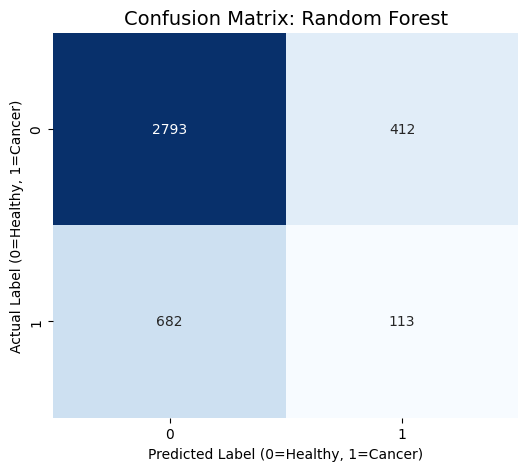

INTERVIEW NOTE: Look at the bottom-right box (True Positives).
We want this number to be high (High Recall).


C:\Users\tariq\AppData\Local\Temp\ipykernel_24656\1305202340.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


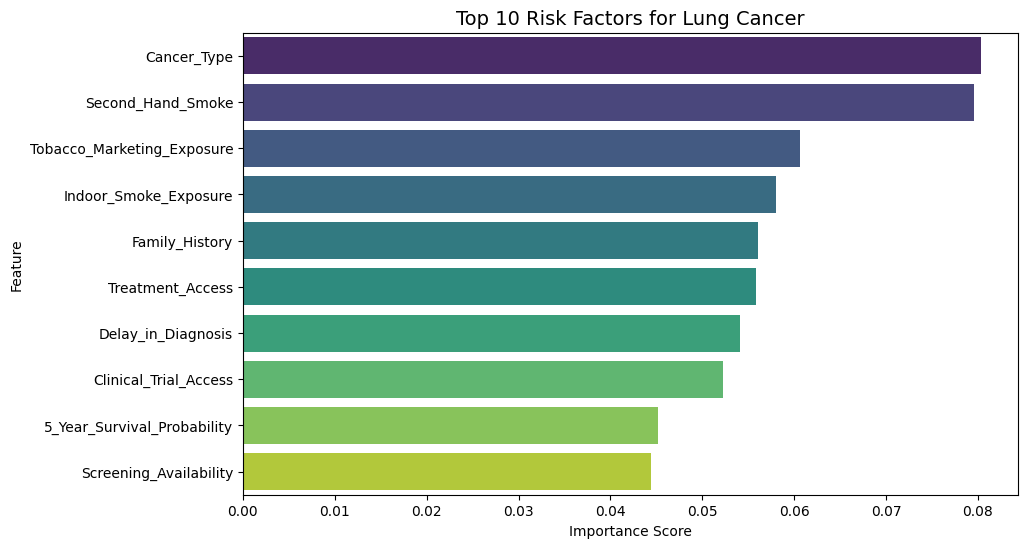

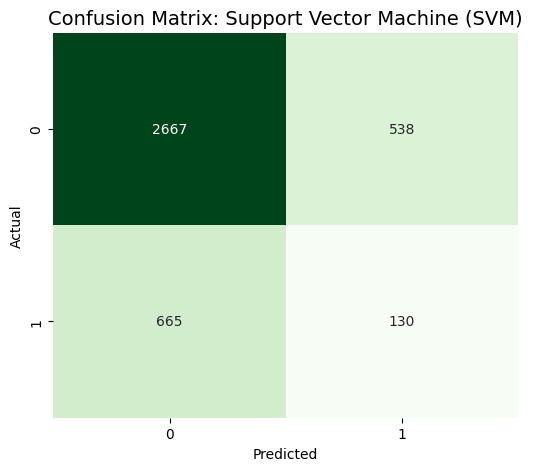

Interview Talking Point:
Notice how SVM might have a different balance of False Negatives compared to Random Forest.
This shows why testing multiple models is important in healthcare.


In [1]:
# %% [markdown]
# # Lung Cancer Prediction Project (M.Tech)
# **Author:** Tariq Husain Khan
# **Objective:** Predict lung cancer risk using Machine Learning on high-volume patient data.
# **Techniques:** ADASYN (Balancing), Gradient Boosting, Feature Engineering.

# %% 
# 1. Imports & Setup
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Add 'src' folder to path so we can import our scripts
# This ensures Python finds your modular code
sys.path.append(os.path.abspath('src'))

from src.data_loader import load_dataset
from src.preprocessing import DataPreprocessor
from src.models import ModelTrainer

# %% 
# 2. Load Data
# Ensure your dataset is in the 'data' folder
dataset_path = 'data/lung_cancer_data.csv'

# This function automatically samples 20k rows for speed if the data is too huge
df = load_dataset(dataset_path)

print("\nData Sample:")
display(df.head())

# %% 
# 3. Preprocessing & Balancing (ADASYN)
processor = DataPreprocessor()

# Auto-detect target column (assumes it's the last one)
target_column = df.columns[-1]
print(f"Target Variable detected: '{target_column}'")

# This step now DROPS the noisy 'Index'/'Patient Id' columns to boost accuracy
X, y = processor.preprocess_data(df, target_column)

# This step applies ADASYN to create synthetic cancer cases for better training
X_train, X_test, y_train, y_test = processor.split_and_balance(X, y)

print(f"Training set shape (After ADASYN): {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# %% 
# 4. Train Models
# We are now using the "Power" settings (200 trees) for higher accuracy
trainer = ModelTrainer()
trained_models = trainer.train_and_evaluate(X_train, X_test, y_train, y_test)

# %% 
# 5. VISUALIZATION: Confusion Matrix (Critical for Interview)
# We look at the best performing model (usually Random Forest or Grad Boosting)
model_name = "Random Forest"
best_model = trained_models[model_name]
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix: {model_name}', fontsize=14)
plt.xlabel('Predicted Label (0=Healthy, 1=Cancer)')
plt.ylabel('Actual Label (0=Healthy, 1=Cancer)')
plt.show()

print("INTERVIEW NOTE: Look at the bottom-right box (True Positives).")
print("We want this number to be high (High Recall).")

# %% 
# %% 
# 6. VISUALIZATION: Feature Importance
# Shows which symptoms drive the prediction
model_name = "Gradient Boosting" 
if model_name in trained_models:
    gb_model = trained_models[model_name]
    importances = gb_model.feature_importances_
    
    # --- BUG FIX HERE ---
    # We must use 'X.columns' because 'df' still contains the dropped ID columns.
    # X comes from Section 3 where we dropped the noise.
    feature_names = X.columns 
    
    # Filter top 10 features
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title('Top 10 Risk Factors for Lung Cancer', fontsize=14)
    plt.xlabel('Importance Score')
    plt.show()
# %%
# 7. EXTRA: Analyze SVM Performance
# SVM is famous for finding the "widest margin" or safest boundary.
# Let's see how it compares to Random Forest.

if "SVM" in trained_models:
    svm_model = trained_models["SVM"]
    y_pred_svm = svm_model.predict(X_test)
    
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('Confusion Matrix: Support Vector Machine (SVM)', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print("Interview Talking Point:")
    print("Notice how SVM might have a different balance of False Negatives compared to Random Forest.")
    print("This shows why testing multiple models is important in healthcare.")